In [10]:
%matplotlib inline

# imports
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import os

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

In [16]:
# load psd, fooof & dfa results
def load_results(basefolder, filename, load_psd=True, load_fooof=True, load_dfa=True):
    psd_data, fooof_data, dfa_data = [], [], []
    if load_psd:
        psd_data = np.load(basefolder+'psd/'+filename)
        print(list(psd_data.keys()))
    if load_fooof:
        fooof_data = np.load(basefolder+'psd/fooof/'+filename)
        print(list(fooof_data.keys()))
    if load_dfa:    
        dfa_data = np.load(basefolder+'dfa/'+filename)
        print(list(dfa_data.keys()))
    
    return psd_data, fooof_data, dfa_data


def load_fooof_results(basefolder, filename):
    fooof_data = np.load(basefolder+filename)
    print(list(fooof_data.keys()))
    return fooof_data

def tau_from_C(knee):
    return np.sqrt(1/knee)/(2*np.pi)

![](../../img/chibi_murray.png)

In [17]:
# loading all fooof results
fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/'
fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])
conds = ['EyesOpen', 'EyesClosed', 'Delivery', 'Anesthesia']
cond = conds[0]
fit_type = 'bg_kn_med' #bg_kn, bg_kn_med
fit_feat = 'knee'

fits, subj = [],[]
for ff in fooof_files:
    metadata = [ff.split('_')[i] for i in [1,2,3,7]]
    if cond in metadata:
        fooof_data=np.load(fooof_path+ff)
        fits.append(fooof_data[fit_type])
        subj.append(metadata[-1])
            
fits = np.dstack(fits)

# collect data from electrodes
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {}

# consult map for these coords
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

ecog_ts = {}
ecog_ts_avg = {}
for i,key in enumerate(cell_ts.keys()):
    ecog_ts[key]=[]
    for rec in range(fits.shape[2]):
        cur_locs = np.array(loc_inds[subj[rec]][key])-1
        if fit_feat is 'knee':
            ecog_ts[key].append(tau_from_C(fits[cur_locs,1,rec])*1000)
        elif fit_feat is 'slope':
            ecog_ts[key].append(fits[cur_locs,-1,rec])

    ecog_ts_avg[key] = np.array([[np.nanmean(ts), np.nanstd(ts)] for ts in ecog_ts[key]])
    cell_ts_avg[key] = np.array([np.mean(cell_ts[key]), np.std(cell_ts[key])])

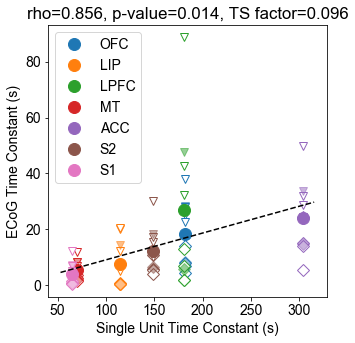

In [18]:
_, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels=['D','v']
loc_ord = ['OFC', 'LIP', 'LPFC', 'MT', 'ACC', 'S2', 'S1']
plot_ord = [4,2,3,1,5,7,6]

# plotting
plt.figure(figsize=(5,5))
for i,key in enumerate(loc_ord):
    for s in np.unique(subj_ind):
        plt.plot(cell_ts_avg[key][0]*np.ones(sum(subj_ind==s)), ecog_ts_avg[key][subj_ind==s,0], labels[s], alpha=1, ms=8, mfc='w',color=CKEYS[i])
        plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][subj_ind==s,0].mean(), labels[s], alpha=0.5, ms=8, color=CKEYS[i])
    plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean(), 'o', ms=12, label=key, color=CKEYS[i])

plt.legend()
plt.xlabel('Single Unit Time Constant (s)')
plt.ylabel('ECoG Time Constant (s)')

# stats on grand average
ts_means = np.array([[cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean()] for key in loc_ord])
W = np.polyfit(ts_means[:,0],ts_means[:,1],1)
XL = np.array(plt.xlim())
plt.plot(XL, XL*W[0]+W[1], 'k--')
rho,pv = sp.stats.pearsonr(ts_means[:,0], ts_means[:,1])
plt.title('rho=%.3f, p-value=%.3f, TS factor=%0.3f'%(rho,pv,W[0]));